Sierpinksi Triangle


Generado Sierpinski hasta iteración=7
Total de sub-triángulos = 1093
Total de puntos distintos = 1095


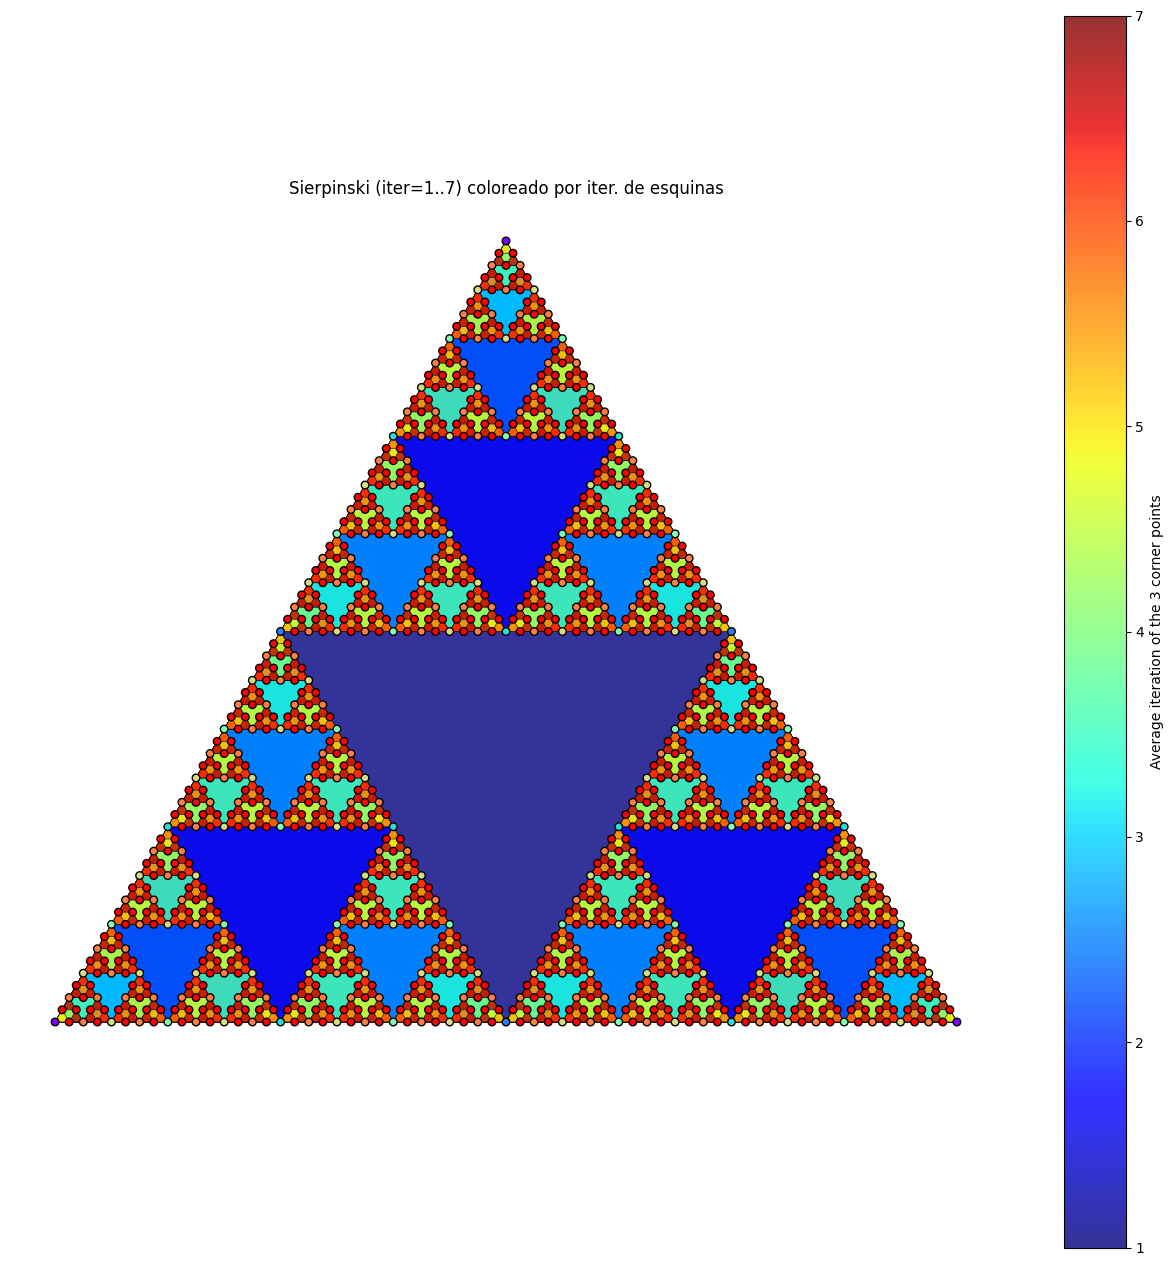

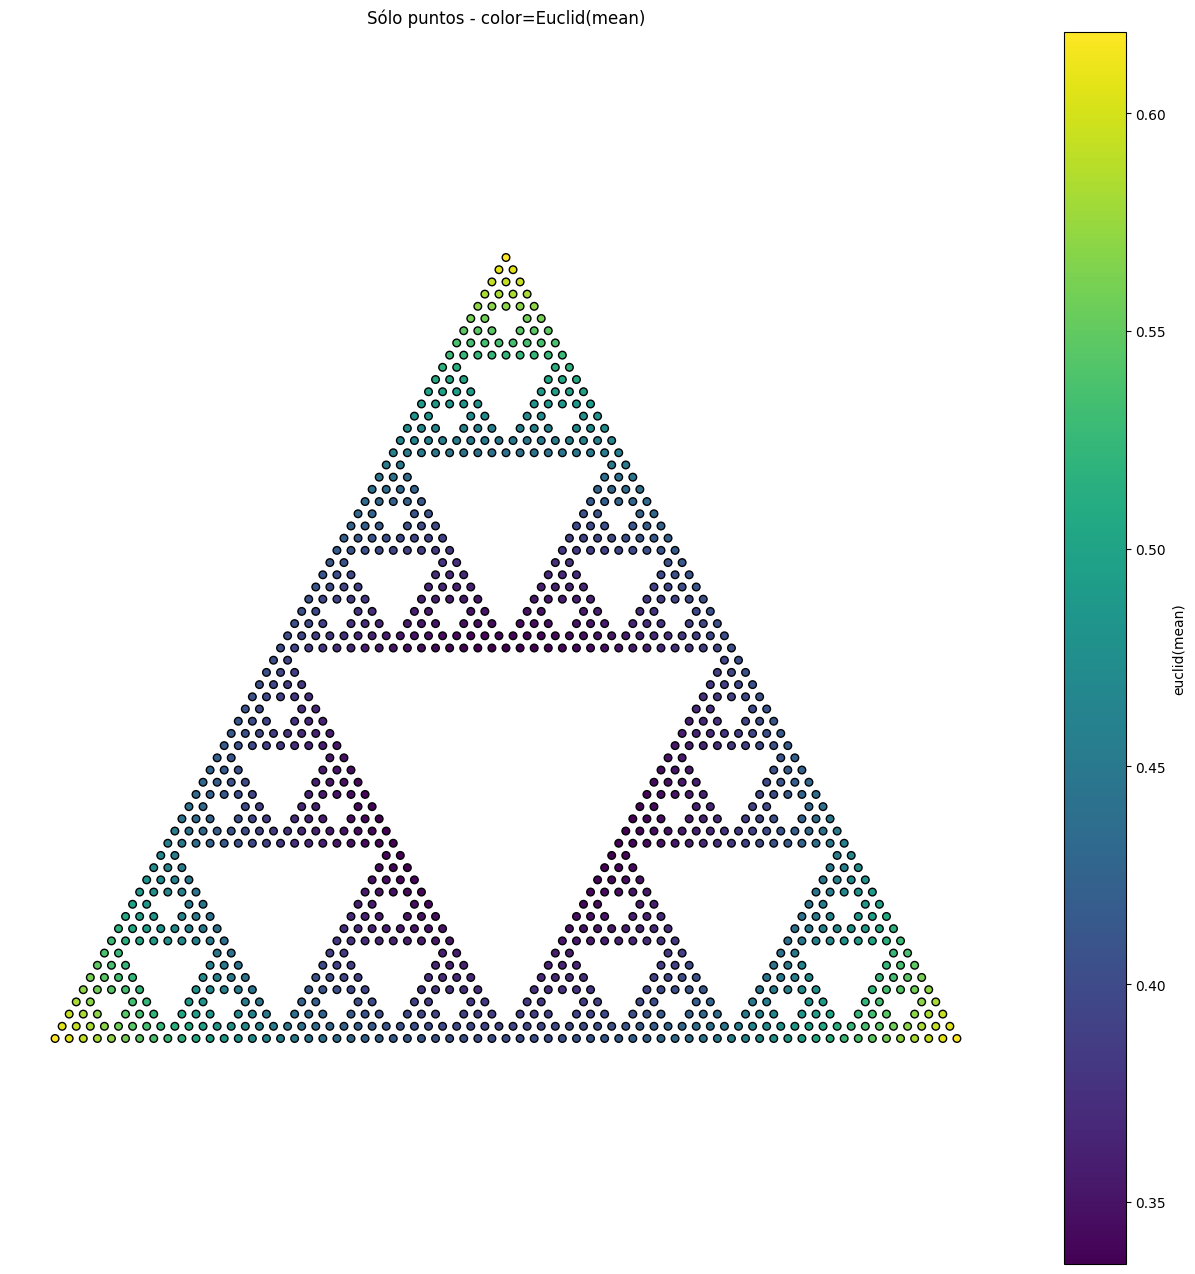

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Para colorear fácilmente sub-triángulos
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# ------------------------------------------------------------------------
# 1) GENERACIÓN DE TRIÁNGULOS (Y PUNTOS) DE SIERPINSKI
# ------------------------------------------------------------------------

def midpoint(A, B):
    """Retorna el punto medio entre A=(x1,y1) y B=(x2,y2)."""
    return ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)

def subdivide_triangle(tri):
    """
    Dado tri = ((x1,y1),(x2,y2),(x3,y3)),
    retorna los 3 sub-triángulos de las esquinas
    (descartando el central).
    """
    A, B, C = tri
    AB_mid = midpoint(A, B)
    BC_mid = midpoint(B, C)
    CA_mid = midpoint(C, A)
    # Los 3 subtriángulos
    t1 = (A, AB_mid, CA_mid)
    t2 = (B, BC_mid, AB_mid)
    t3 = (C, CA_mid, BC_mid)
    return [t1, t2, t3]

def sierpinski_triangles_and_points(k):
    """
    Genera:
      1) triangles_by_iter[i]: lista de triángulos que nacen en la iteración i
         (i = 1..k).
      2) points_list: lista de (x,y, iterAparicion) para TODOS los vértices
         que aparecen hasta la iteración k.

    El "triángulo inicial" (iter=1) es equilátero con vértices:
       (0,0), (1,0) y (0.5, sqrt(3)/2).
    """

    # Diccionario: i -> [ ( (x1,y1), (x2,y2), (x3,y3) ), ... ]
    triangles_by_iter = {}

    # Diccionario para registrar la iter de aparición de cada punto (x,y)
    point_appearance = {}

    # Iteración 1: un solo triángulo base
    t0 = ((0,0), (1,0), (0.5, np.sqrt(3)/2))
    triangles_by_iter[1] = [t0]

    # Registrar sus 3 vértices como aparecidos en iter=1
    for v in t0:
        if v not in point_appearance:
            point_appearance[v] = 1

    # Subdividir para iteraciones sucesivas
    for i in range(2, k+1):
        new_tris = []
        # Tomar todos los triángulos de la iteración previa
        for tri in triangles_by_iter[i-1]:
            subs = subdivide_triangle(tri)
            # Para cada subtriángulo de la "nueva" iteración
            for st in subs:
                new_tris.append(st)
                # Registrar sus vértices si no existían
                for v in st:
                    if v not in point_appearance:
                        point_appearance[v] = i
        triangles_by_iter[i] = new_tris

    # Construir la lista final de puntos (x,y, iterAparicion)
    points_list = []
    for (px,py), itap in point_appearance.items():
        points_list.append((px, py, itap))

    return triangles_by_iter, points_list

# ------------------------------------------------------------------------
# 2) CÁLCULO DE DISTANCIAS Y ESTADÍSTICAS
# ------------------------------------------------------------------------

def distance_euclid(p1, p2):
    """ Distancia Euclidiana entre p1=(x1,y1,iter1) y p2=(x2,y2,iter2). """
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def distance_manhattan(p1, p2):
    """ Distancia Manhattan """
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def distance_minkowski(p1, p2, p=3):
    """ Distancia Minkowski con p=3 """
    return ( (abs(p1[0]-p2[0]))**p + (abs(p1[1]-p2[1]))**p )**(1.0/p)

def distance_aparicion(p1, p2):
    """ Distancia de 'aparición' = |iter1 - iter2| """
    return abs(p1[2] - p2[2])

def compute_distance_data(points):
    """
    Dada la lista de puntos 'points' (cada uno = (x,y,iter)), 
    calcula, para cada punto, sus distancias a todos los demás
    en las métricas: Euclid, Manhattan, Minkowski(p=3), Aparición.

    Retorna un diccionario dist_data[i], donde i es el índice 
    del punto en 'points', y:
        dist_data[i] = {
          'point': (x,y,iter),
          'euclid':    { 'values': [...], 'min':..., 'max':..., 'mean':..., 'median':... },
          'manhattan': { ... },
          'minkowski': { ... },
          'aparicion': { ... }
        }
    """
    n = len(points)
    dist_data = {}

    def stats(arr):
        arr_np = np.array(arr)
        return {
            'values': arr,
            'min': float(np.min(arr_np)) if len(arr_np)>0 else 0.0,
            'max': float(np.max(arr_np)) if len(arr_np)>0 else 0.0,
            'mean': float(np.mean(arr_np)) if len(arr_np)>0 else 0.0,
            'median': float(np.median(arr_np)) if len(arr_np)>0 else 0.0
        }

    for i in range(n):
        p_i = points[i]
        dist_eu = []
        dist_man = []
        dist_mink = []
        dist_ap = []
        for j in range(n):
            if i == j:
                continue
            p_j = points[j]
            dist_eu.append(distance_euclid(p_i, p_j))
            dist_man.append(distance_manhattan(p_i, p_j))
            dist_mink.append(distance_minkowski(p_i, p_j, p=3))
            dist_ap.append(distance_aparicion(p_i, p_j))

        dist_data[i] = {
            'point': p_i,
            'euclid': stats(dist_eu),
            'manhattan': stats(dist_man),
            'minkowski': stats(dist_mink),
            'aparicion': stats(dist_ap)
        }
    return dist_data

# ------------------------------------------------------------------------
# 3) FUNCIÓN PARA COLOREAR SUB-TRIÁNGULOS SEGÚN LAS ITERACIONES
#    DE SUS VÉRTICES
# ------------------------------------------------------------------------

def plot_sierpinski_colored_by_corners(triangles_by_iter, points_list,
                                       title="Sierpinski colored by corner iterations"):
    """
    "Colorea" cada sub-triángulo usando la media de las iteraciones de sus 3 esquinas.
    Además, dibuja los puntos (vértices) coloreados por su iteración de aparición.
    """
    # Construimos un dict: (x,y) -> iterAparicion
    point_iter = { (px,py): itap for (px,py,itap) in points_list }

    # Reunimos todos los sub-triángulos en una lista de "Polygon" patches,
    # y calculamos el "valor" (average iteration) que usaremos para el color.
    patches = []
    color_values = []

    all_iters = sorted(triangles_by_iter.keys())  # 1..k
    for i in all_iters:
        for tri in triangles_by_iter[i]:
            (A, B, C) = tri
            iA = point_iter[A]
            iB = point_iter[B]
            iC = point_iter[C]
            avg_iter = (iA + iB + iC) / 3.0  # media de iteraciones de sus esquinas

            polygon = mpatches.Polygon([A, B, C], closed=True)
            patches.append(polygon)
            color_values.append(avg_iter)

    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.set_axis_off()

    # Creamos una "PatchCollection" para colorear todos los triángulos
    pc = PatchCollection(patches, cmap='jet', alpha=0.8, edgecolor='black', linewidth=0.5)
    pc.set_array(np.array(color_values))
    # Asumimos que el rango de iteraciones va de 1..(máximo). Ej: 1..7
    pc.set_clim(1, max(all_iters))

    ax.add_collection(pc)
    cbar = fig.colorbar(pc, ax=ax)
    cbar.set_label("Average iteration of the 3 corner points")

    # Sobreponemos los puntos, coloreados según la iteración en que aparecen
    arr_p = np.array(points_list)  # [ [x,y,iter], ... ]
    x, y, iters = arr_p[:,0], arr_p[:,1], arr_p[:,2]
    sc = ax.scatter(x, y, c=iters, cmap='rainbow', edgecolors='k', s=30, zorder=5)
    # Si quisieras otra colorbar para los puntos, la puedes crear con:
    # cb2 = fig.colorbar(sc, ax=ax)
    # cb2.set_label("Iter. aparición (para puntos)")
    # (pero tendrías 2 barras de color superpuestas)

    plt.show()

# ------------------------------------------------------------------------
# 4) OPCIONAL: graficar los puntos usando alguna métrica (euclid, manhattan, etc.)
#    igual que en ejemplos anteriores
# ------------------------------------------------------------------------

def plot_points_by_metric(points_list, dist_data, metric="euclid", stat="mean", title=None):
    """
    Grafica sólo los puntos (scatter), coloreados según (por ejemplo)
    la distancia euclidiana media a los demás.
    """
    if title is None:
        title = f"{metric} - {stat}"

    arr_p = np.array(points_list)
    x, y = arr_p[:,0], arr_p[:,1]

    # Extraemos la estadística solicitada
    values = []
    for i in range(len(points_list)):
        v = dist_data[i][metric][stat]
        values.append(v)
    values = np.array(values)

    plt.figure(figsize=(16,16))
    sc = plt.scatter(x, y, c=values, cmap='viridis', s=30, edgecolors='k')
    plt.colorbar(sc, label=f"{metric}({stat})")
    plt.title(title)
    plt.axis("equal")
    plt.axis("off")
    plt.show()

# ------------------------------------------------------------------------
# EJEMPLO DE USO
# ------------------------------------------------------------------------

if __name__ == "__main__":

    # (1) Generamos el Triángulo de Sierpinski hasta iteración 7
    K = 7
    triangles_by_iter, points_list = sierpinski_triangles_and_points(K)
    print(f"\nGenerado Sierpinski hasta iteración={K}")
    total_tris = sum(len(triangles_by_iter[i]) for i in triangles_by_iter)
    print(f"Total de sub-triángulos = {total_tris}")
    print(f"Total de puntos distintos = {len(points_list)}")

    # (2) Calculamos las distancias y estadísticas
    dist_data = compute_distance_data(points_list)

    # (3) Graficar sub-triángulos con color basado en la media de iteraciones
    #     de sus vértices ("color of their corner points").
    plot_sierpinski_colored_by_corners(triangles_by_iter, points_list,
        title=f"Sierpinski (iter=1..{K}) coloreado por iter. de esquinas")

    # (4) [Opcional] Graficar sólo los puntos según, por ejemplo,
    #     la distancia Euclidiana media a los demás:
    plot_points_by_metric(points_list, dist_data, metric="euclid", stat="mean",
                          title=f"Sólo puntos - color=Euclid(mean)")


Generado Sierpinski hasta iter=4.


C:\Users\thano\AppData\Local\Temp\ipykernel_572\1839955216.py:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_iter = plt.cm.get_cmap('tab10', num_colors)


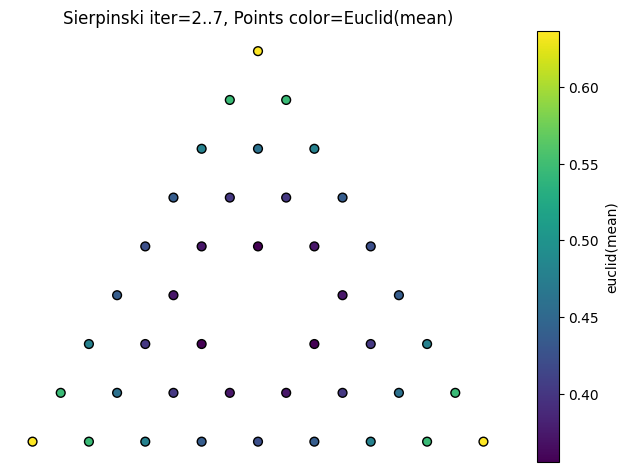

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# ------------------------------------------------------------------------
# 1) GENERACIÓN DE TRIÁNGULOS (Y PUNTOS) DE SIERPINSKI
# ------------------------------------------------------------------------

def midpoint(A, B):
    return ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)

def subdivide_triangle(tri):
    A, B, C = tri
    AB_mid = midpoint(A, B)
    BC_mid = midpoint(B, C)
    CA_mid = midpoint(C, A)
    return [
        (A, AB_mid, CA_mid),
        (B, BC_mid, AB_mid),
        (C, CA_mid, BC_mid)
    ]

def sierpinski_triangles_and_points(k):
    """
    Genera:
      1) triangles_by_iter[i]: lista de sub-triángulos que nacen en la iteración i
      2) points_list: lista de (x,y,iterAparicion) de TODOS los vértices generados.
    """
    triangles_by_iter = {}
    point_appearance = {}

    # Iteracion 1: triángulo base
    t0 = ((0,0), (1,0), (0.5, np.sqrt(3)/2))
    triangles_by_iter[1] = [t0]
    for v in t0:
        point_appearance[v] = 1

    # Subdividir
    for i in range(2, k+1):
        new_tris = []
        for tri in triangles_by_iter[i-1]:
            subs = subdivide_triangle(tri)
            new_tris.extend(subs)
            for st in subs:
                for v in st:
                    if v not in point_appearance:
                        point_appearance[v] = i
        triangles_by_iter[i] = new_tris

    points_list = [(px, py, itap) for ((px,py), itap) in point_appearance.items()]
    return triangles_by_iter, points_list

# ------------------------------------------------------------------------
# 2) DISTANCIAS Y ESTADÍSTICAS
# ------------------------------------------------------------------------

def distance_euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def distance_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def distance_minkowski(p1, p2, p=3):
    return ((abs(p1[0]-p2[0]))**p + (abs(p1[1]-p2[1]))**p)**(1.0/p)

def distance_aparicion(p1, p2):
    return abs(p1[2] - p2[2])

def compute_distance_data(points):
    dist_data = {}
    def stats(arr):
        import numpy as np
        arr_np = np.array(arr)
        return {
            'values': arr,
            'min': float(np.min(arr_np)) if len(arr_np)>0 else 0.0,
            'max': float(np.max(arr_np)) if len(arr_np)>0 else 0.0,
            'mean': float(np.mean(arr_np)) if len(arr_np)>0 else 0.0,
            'median': float(np.median(arr_np)) if len(arr_np)>0 else 0.0
        }
    n = len(points)
    for i in range(n):
        p_i = points[i]
        dist_eu, dist_man, dist_mink, dist_ap = [], [], [], []
        for j in range(n):
            if i == j:
                continue
            p_j = points[j]
            dist_eu.append(distance_euclid(p_i, p_j))
            dist_man.append(distance_manhattan(p_i, p_j))
            dist_mink.append(distance_minkowski(p_i, p_j, p=3))
            dist_ap.append(distance_aparicion(p_i, p_j))
        dist_data[i] = {
            'point': p_i,
            'euclid':    stats(dist_eu),
            'manhattan': stats(dist_man),
            'minkowski': stats(dist_mink),
            'aparicion': stats(dist_ap)
        }
    return dist_data

# ------------------------------------------------------------------------
# 3) FUNCIÓN: Conectar/colorear sub-triángulos SOLO de iter>=2
#    cada iteración con un color único, y colorear puntos por la métrica
# ------------------------------------------------------------------------

def plot_triangles_iter2_and_points_metric(triangles_by_iter, 
                                           points_list,
                                           dist_data,
                                           metric="euclid",
                                           stat="mean",
                                           title=None):
    """
    - Dibuja SÓLO los sub-triángulos "puros" de iter=2..k, 
      ignorando iter=1.
    - Asigna un color distinto a cada iteración i, i=2..k.
    - Los puntos (todos) se colorean según la métrica/estadística (una colorbar).
    - Se crea una leyenda que muestre los colores de las iteraciones 2..k.
    """
    if title is None:
        title = f"Sierpinski Triangles from iter=2.. + Points color={metric}({stat})"

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.set_axis_off()

    # Diccionario (x,y)->iter
    iter_dict = { (px,py): itap for (px,py,itap) in points_list }

    # Determinamos la cantidad máxima de iteraciones
    max_iter = max(triangles_by_iter.keys())

    # Usaremos un colormap discreto con (max_iter-1) colores
    # para iteraciones = 2..max_iter
    num_colors = max_iter - 1
    cmap_iter = plt.cm.get_cmap('tab10', num_colors)

    # Para la leyenda
    legend_handles = []

    # Recorremos i=2..k
    for i in range(2, max_iter+1):
        pure_patches = []
        # Filtrar triángulos "puros" cuyos 3 vértices son de iter i
        for tri in triangles_by_iter[i]:
            A, B, C = tri
            if iter_dict[A] == i and iter_dict[B] == i and iter_dict[C] == i:
                pure_patches.append(mpatches.Polygon([A, B, C], closed=True))
        
        if pure_patches:
            color_i = cmap_iter(i-2)  # i-2 => 0-based index
            pc = PatchCollection(pure_patches, facecolor=color_i,
                                 edgecolor='black', linewidth=0.8, alpha=0.8)
            ax.add_collection(pc)
            # Leyenda
            patch_for_legend = mpatches.Patch(color=color_i, label=f"Iteration {i}")
            legend_handles.append(patch_for_legend)

    if legend_handles:
        ax.legend(handles=legend_handles, loc='upper right', title="Triangles by iteration")
    
    # Colorear los puntos según la métrica
    arr_p = np.array(points_list)
    x, y = arr_p[:,0], arr_p[:,1]
    n_points = len(points_list)

    values_for_color = np.zeros(n_points)
    for idx in range(n_points):
        values_for_color[idx] = dist_data[idx][metric][stat]

    sc = ax.scatter(x, y, c=values_for_color, cmap='viridis', 
                    edgecolors='k', s=40, zorder=5)
    cb = fig.colorbar(sc, ax=ax, shrink=0.7)
    cb.set_label(f"{metric}({stat})")

    plt.show()

# ------------------------------------------------------------------------
# EJEMPLO DE USO
# ------------------------------------------------------------------------

if __name__ == "__main__":
    K = 4
    triangles_by_iter, points_list = sierpinski_triangles_and_points(K)
    print(f"Generado Sierpinski hasta iter={K}.")
    dist_data = compute_distance_data(points_list)

    # Mostramos SOLAMENTE los triángulos "puros" de iter>=2,
    # cada uno con un color distinto,
    # y los puntos coloreados según (por ejemplo) Euclidea (mean).
    plot_triangles_iter2_and_points_metric(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="euclid",
        stat="mean",
        title="Sierpinski iter=2..7, Points color=Euclid(mean)"
    )


C:\Users\thano\AppData\Local\Temp\ipykernel_572\2725119898.py:136: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_iter = plt.cm.get_cmap('tab10', n_colors)


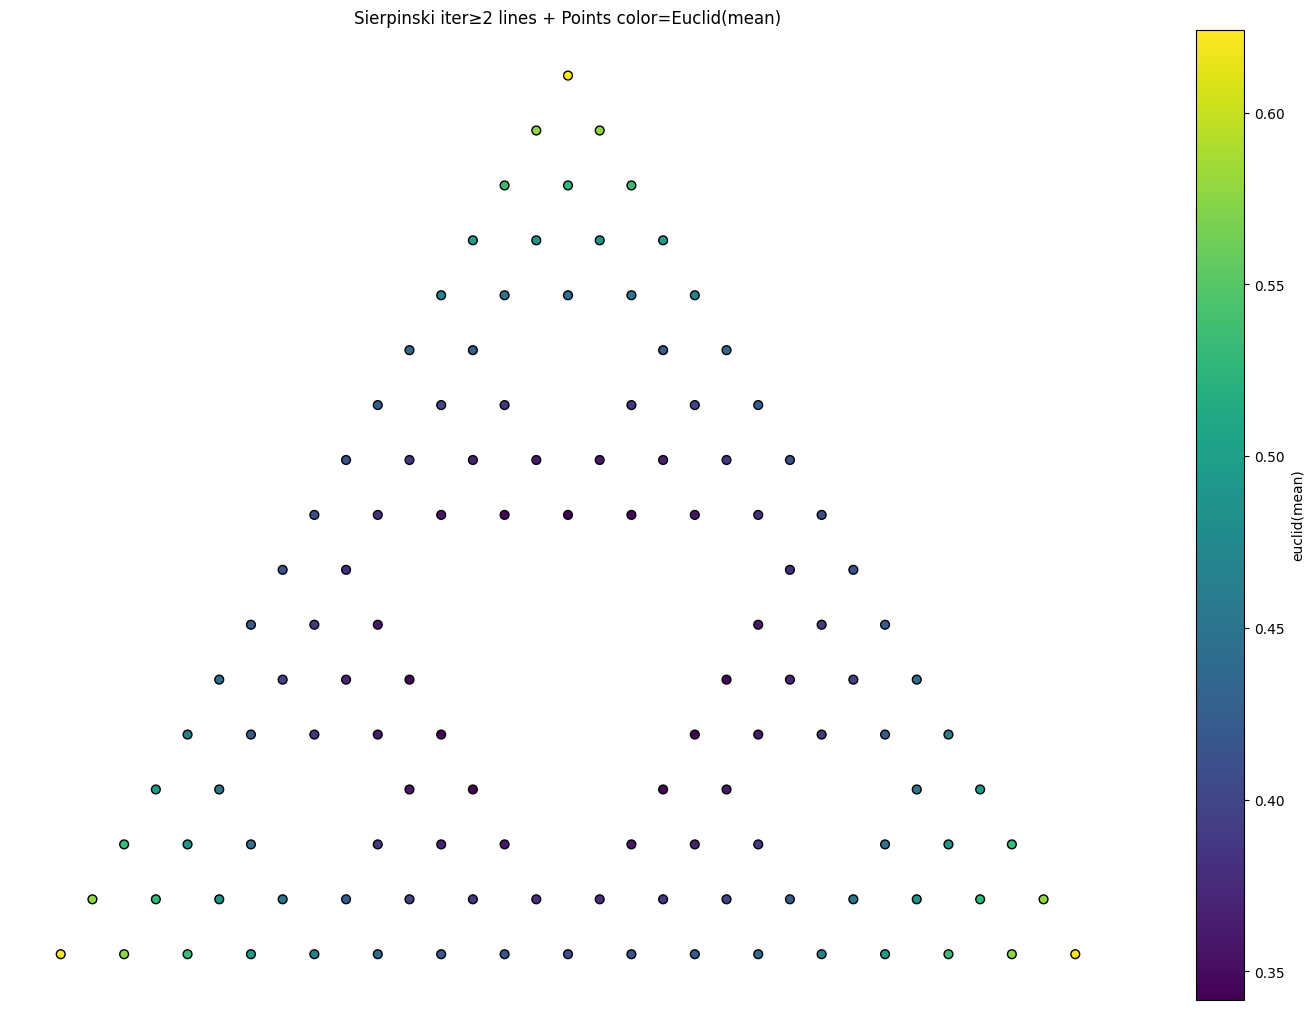

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# ------------------------------------------------------------------------
# 1) GENERACIÓN DE TRIÁNGULOS (Y PUNTOS) DE SIERPINSKI
# ------------------------------------------------------------------------

def midpoint(A, B):
    return ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)

def subdivide_triangle(tri):
    A, B, C = tri
    AB_mid = midpoint(A, B)
    BC_mid = midpoint(B, C)
    CA_mid = midpoint(C, A)
    return [
        (A, AB_mid, CA_mid),
        (B, BC_mid, AB_mid),
        (C, CA_mid, BC_mid)
    ]

def sierpinski_triangles_and_points(k):
    """
    Genera:
      1) triangles_by_iter[i]: lista de sub-triángulos que aparecen en la iteración i
      2) points_list: lista de (x,y, iter) de TODOS los vértices
    """
    triangles_by_iter = {}
    point_appearance = {}

    # Iteración 1: triángulo base
    t0 = ((0,0), (1,0), (0.5, np.sqrt(3)/2))
    triangles_by_iter[1] = [t0]
    for v in t0:
        point_appearance[v] = 1

    for i in range(2, k+1):
        new_tris = []
        for tri in triangles_by_iter[i-1]:
            subs = subdivide_triangle(tri)
            new_tris.extend(subs)
            for st in subs:
                for v in st:
                    if v not in point_appearance:
                        point_appearance[v] = i
        triangles_by_iter[i] = new_tris

    # Construimos la lista final de puntos
    points_list = [(px, py, itap) for ((px,py), itap) in point_appearance.items()]
    return triangles_by_iter, points_list

# ------------------------------------------------------------------------
# 2) CÁLCULO DE DISTANCIAS Y ESTADÍSTICAS
# ------------------------------------------------------------------------

def distance_euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def distance_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def distance_minkowski(p1, p2, p=3):
    return ((abs(p1[0]-p2[0]))**p + (abs(p1[1]-p2[1]))**p)**(1.0/p)

def distance_aparicion(p1, p2):
    return abs(p1[2] - p2[2])

def compute_distance_data(points):
    dist_data = {}
    def stats(arr):
        arr_np = np.array(arr)
        return {
            'values': arr,
            'min': float(np.min(arr_np)) if len(arr_np)>0 else 0.0,
            'max': float(np.max(arr_np)) if len(arr_np)>0 else 0.0,
            'mean': float(np.mean(arr_np)) if len(arr_np)>0 else 0.0,
            'median': float(np.median(arr_np)) if len(arr_np)>0 else 0.0
        }
    n = len(points)
    for i in range(n):
        p_i = points[i]
        dist_eu, dist_man, dist_mink, dist_ap = [], [], [], []
        for j in range(n):
            if i == j:
                continue
            p_j = points[j]
            dist_eu.append(distance_euclid(p_i, p_j))
            dist_man.append(distance_manhattan(p_i, p_j))
            dist_mink.append(distance_minkowski(p_i, p_j, p=3))
            dist_ap.append(distance_aparicion(p_i, p_j))
        dist_data[i] = {
            'point': p_i,
            'euclid':    stats(dist_eu),
            'manhattan': stats(dist_man),
            'minkowski': stats(dist_mink),
            'aparicion': stats(dist_ap)
        }
    return dist_data

# ------------------------------------------------------------------------
# 3) PLOT: Conectar/colorear sub-triángulos SOLO iter>=2 (con lines).
#    Puntos coloreados por la métrica.
# ------------------------------------------------------------------------

def plot_triangles_iter2_and_points_metric(
    triangles_by_iter,
    points_list,
    dist_data,
    metric="euclid",
    stat="mean",
    title=None
):
    """
    - Conecta (plt.plot) SOLO triángulos puros de iter >=2
      (las 3 esquinas tienen la misma iter).
    - A cada iter se le da un color distinto (usando un colormap discreto).
    - Se pone una leyenda con "Iteration 2", "Iteration 3", ...
    - Los puntos se colorean según la métrica/estadística, con colorbar aparte.
    """
    if title is None:
        title = f"Sierpinski Triangles (iter≥2) + Points color={metric}({stat})"

    fig, ax = plt.subplots(figsize=(18,18))
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title)

    # Diccionario: (x,y) -> iter
    iter_dict = { (px,py): itap for (px,py,itap) in points_list }

    max_iter = max(triangles_by_iter.keys())  # K
    # colormap discreto para las iteraciones 2..K
    n_colors = max_iter - 1
    cmap_iter = plt.cm.get_cmap('tab10', n_colors)

    legend_handles = []
    color_index = 0

    # Recorremos i=2..K
    for i in range(2, max_iter+1):
        # color para esta iter i
        color_i = cmap_iter(color_index)
        color_index += 1

        # Recorremos los triángulos de la iter i
        any_found = False
        for tri in triangles_by_iter[i]:
            A, B, C = tri
            if iter_dict[A] == i and iter_dict[B] == i and iter_dict[C] == i:
                # Dibujamos con plt.plot
                xvals = [A[0], B[0], C[0], A[0]]
                yvals = [A[1], B[1], C[1], A[1]]
                ax.plot(xvals, yvals, color=color_i, linewidth=2)
                any_found = True
        
        if any_found:
            # Añadimos un "parche" a la leyenda
            patch_label = f"Iteration {i}"
            # Creamos un rectangle patch (no se dibuja, sólo es para leyenda)
            patch = mpatches.Patch(color=color_i, label=patch_label)
            legend_handles.append(patch)

    if legend_handles:
        ax.legend(handles=legend_handles, loc='upper right',
                  title="Pure triangles by iteration")

    # Ahora coloreamos los puntos por la métrica
    arr_p = np.array(points_list)
    x, y = arr_p[:,0], arr_p[:,1]
    n_points = len(points_list)
    values = np.zeros(n_points)
    for idx in range(n_points):
        values[idx] = dist_data[idx][metric][stat]
    
    sc = ax.scatter(x, y, c=values, cmap='viridis', 
                    edgecolors='black', s=40, zorder=5)

    cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
    cbar.set_label(f"{metric}({stat})")

    plt.show()

# ------------------------------------------------------------------------
# EJEMPLO DE USO
# ------------------------------------------------------------------------
if __name__ == "__main__":
    K = 5
    triangles_by_iter, points_list = sierpinski_triangles_and_points(K)
    dist_data = compute_distance_data(points_list)

    plot_triangles_iter2_and_points_metric(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="euclid",
        stat="mean",
        title="Sierpinski iter≥2 lines + Points color=Euclid(mean)"
    )


C:\Users\thano\AppData\Local\Temp\ipykernel_572\4201976456.py:159: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_iter = plt.cm.get_cmap('tab10', max_iter)


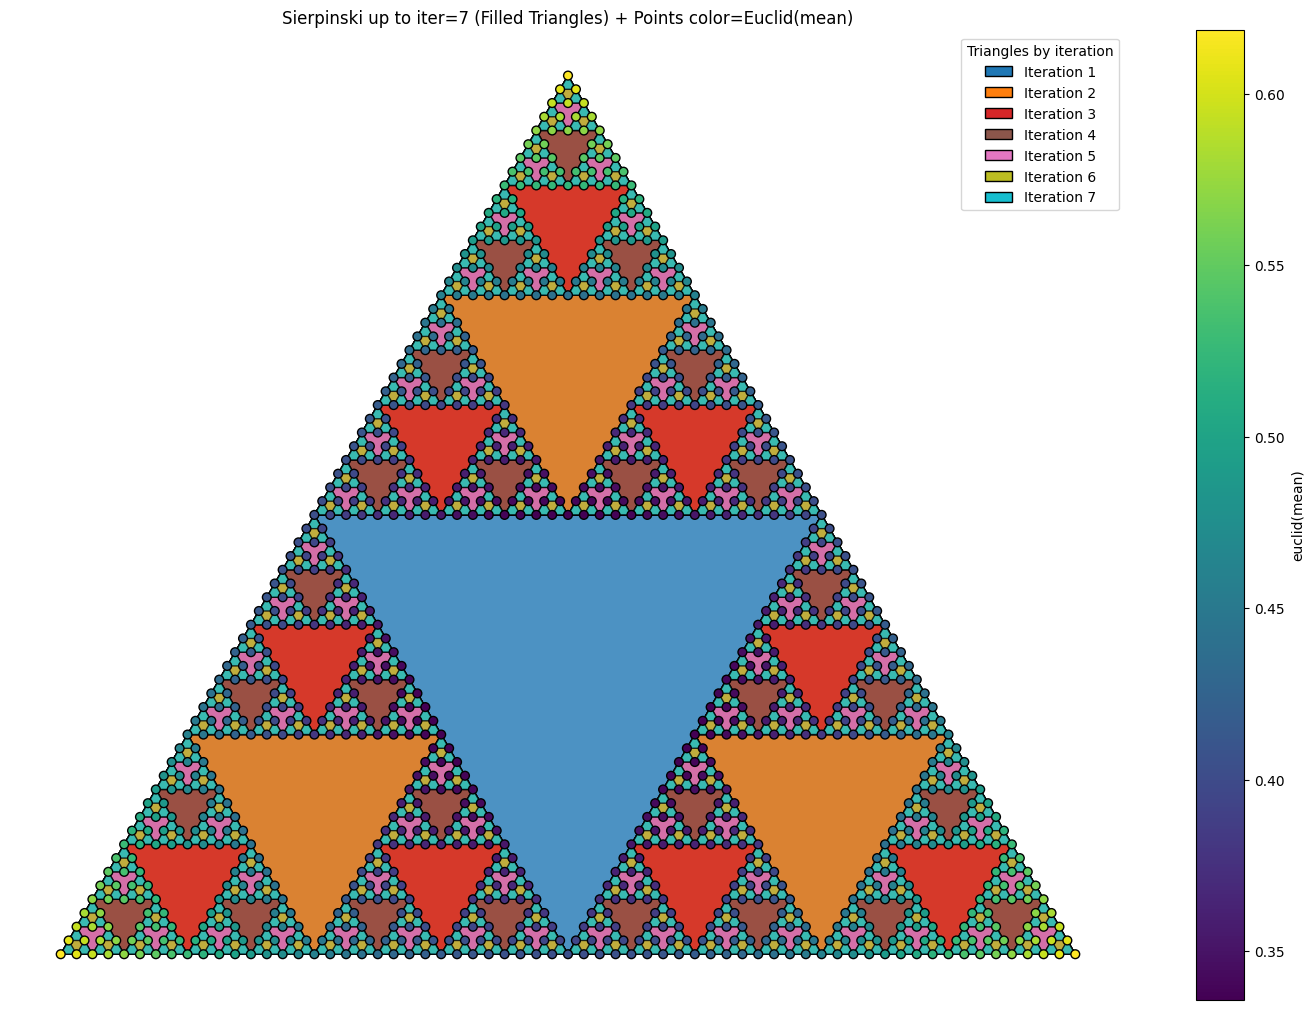

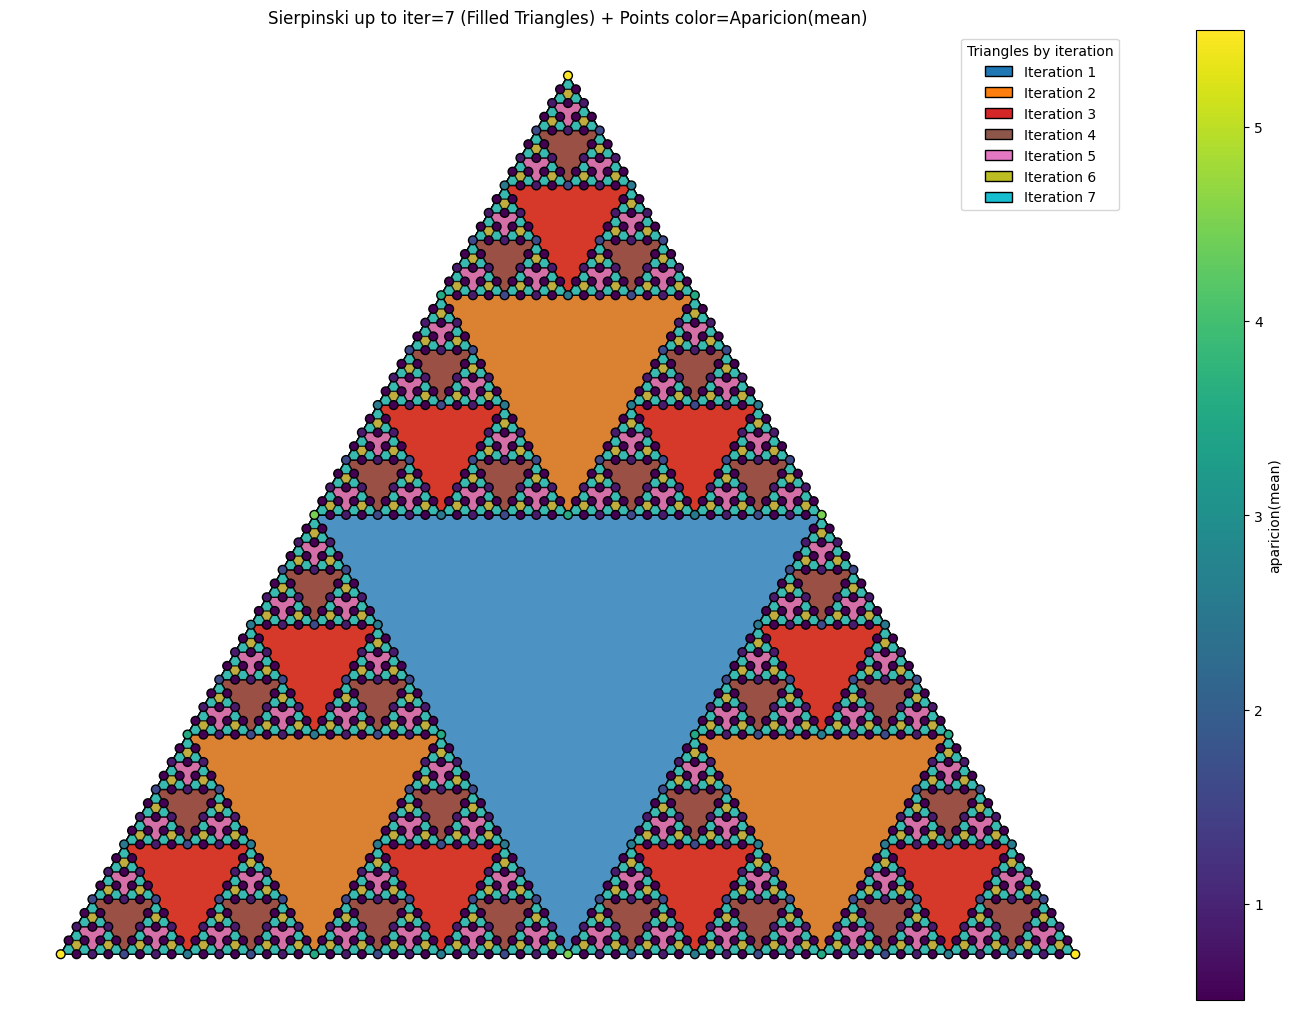

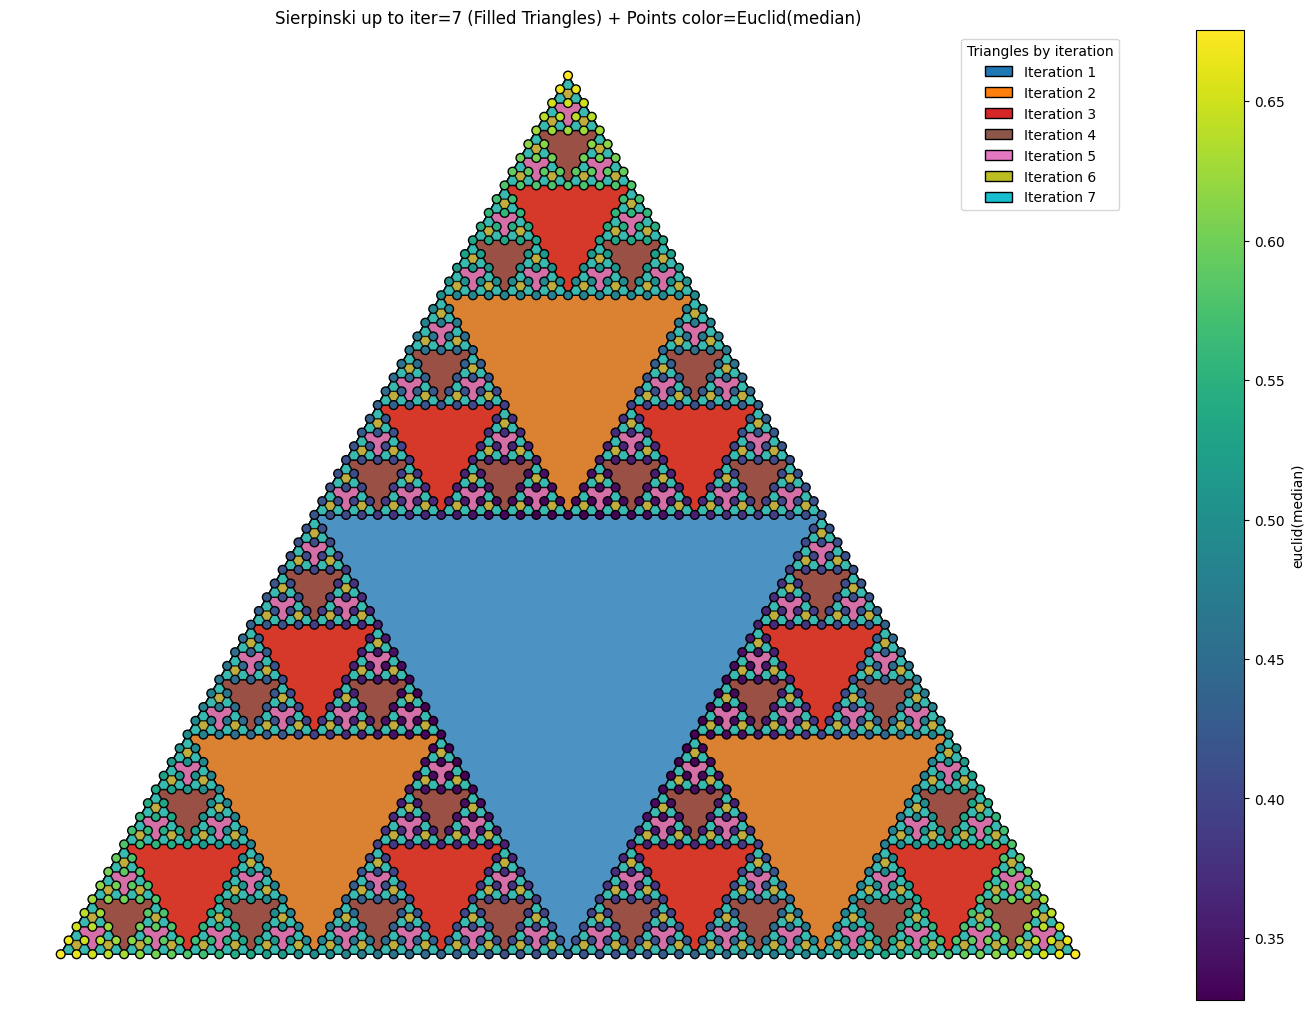

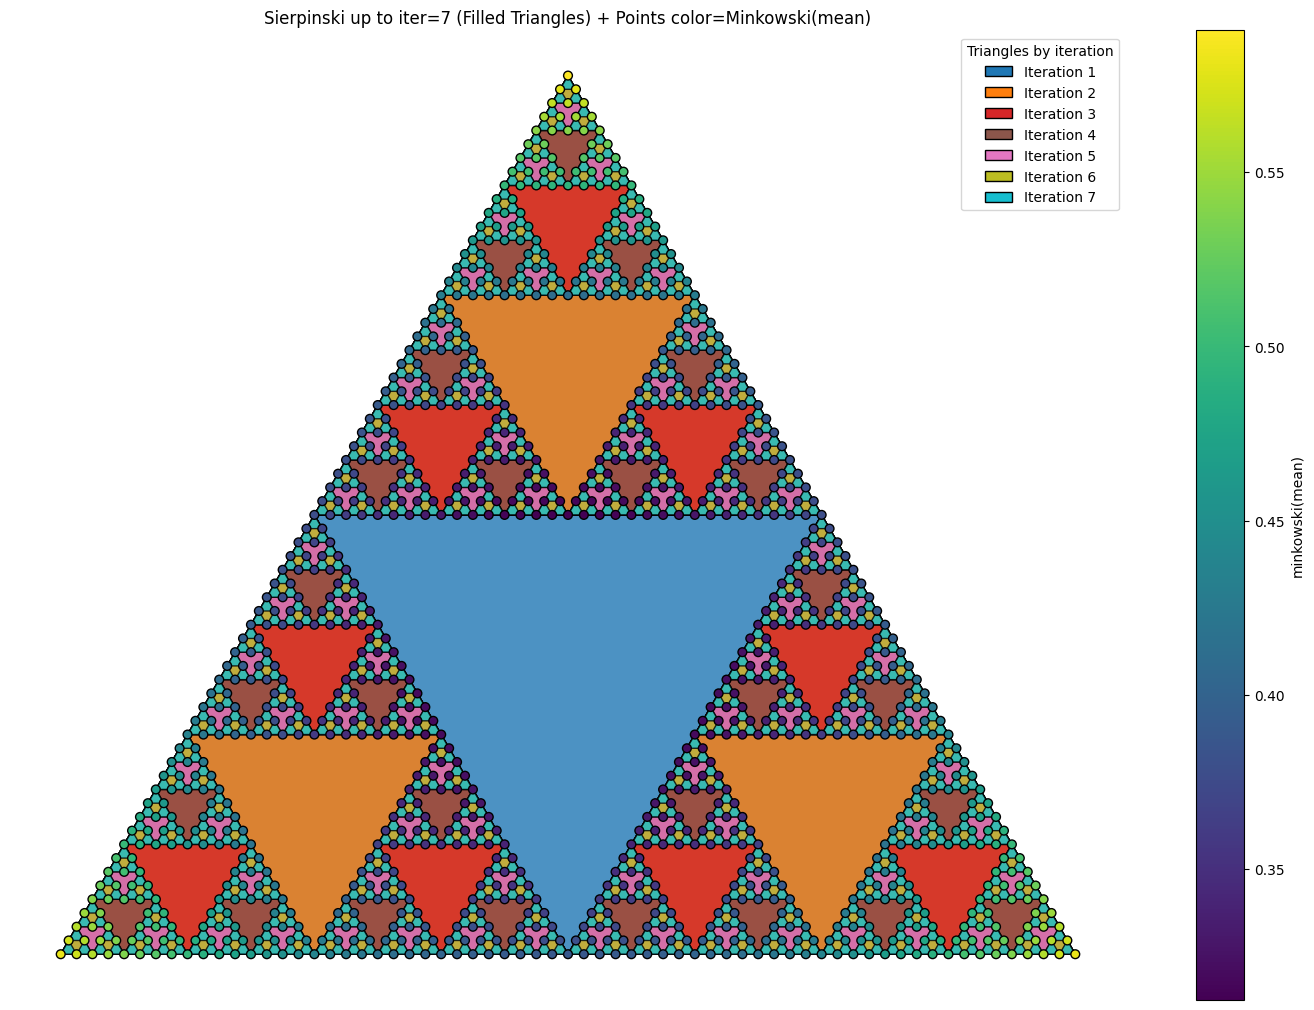

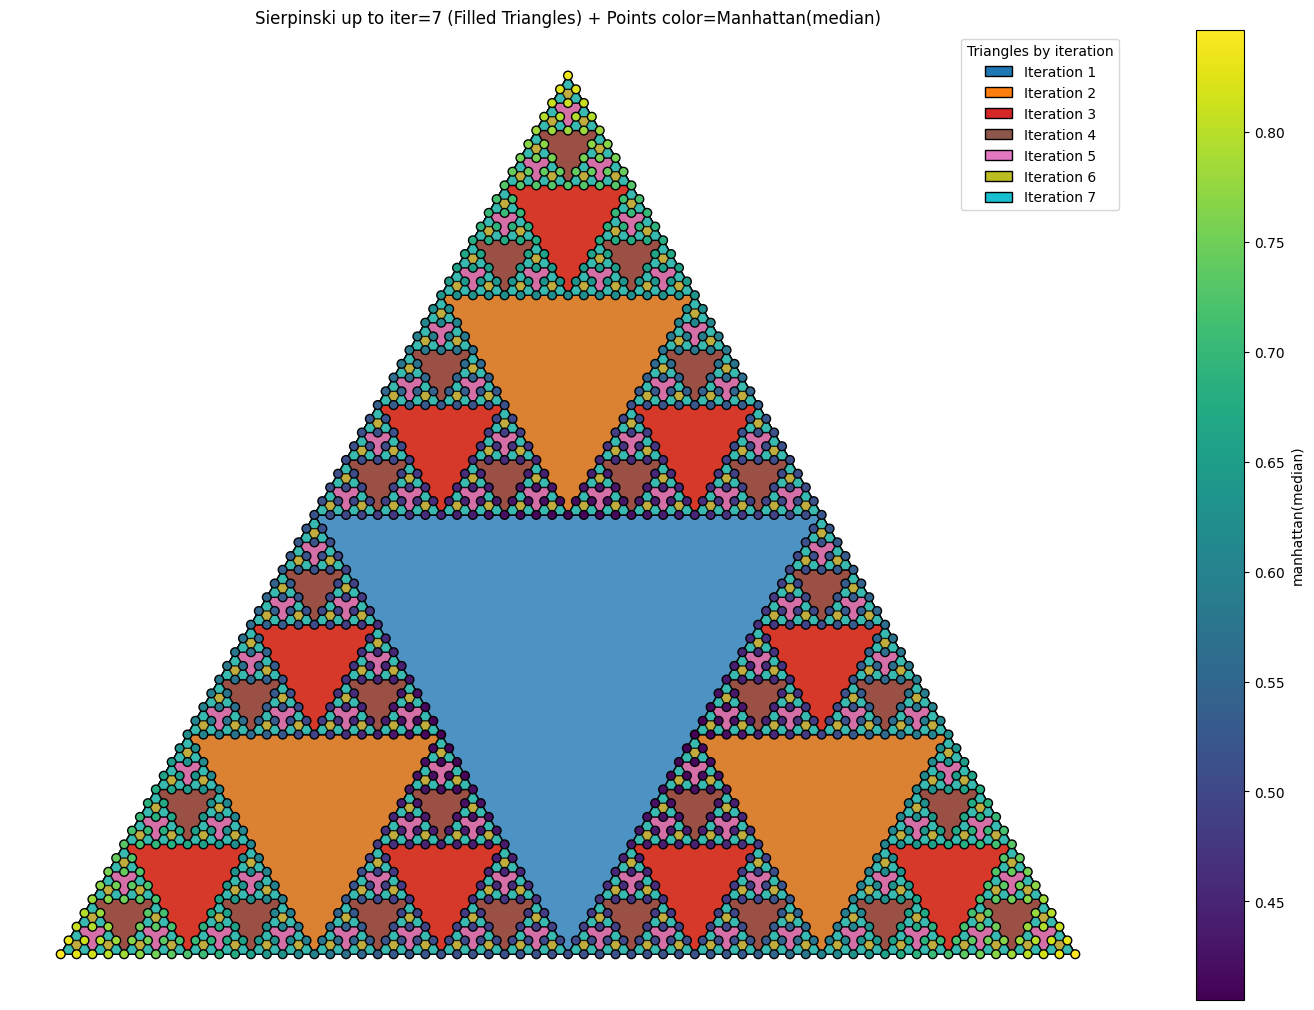

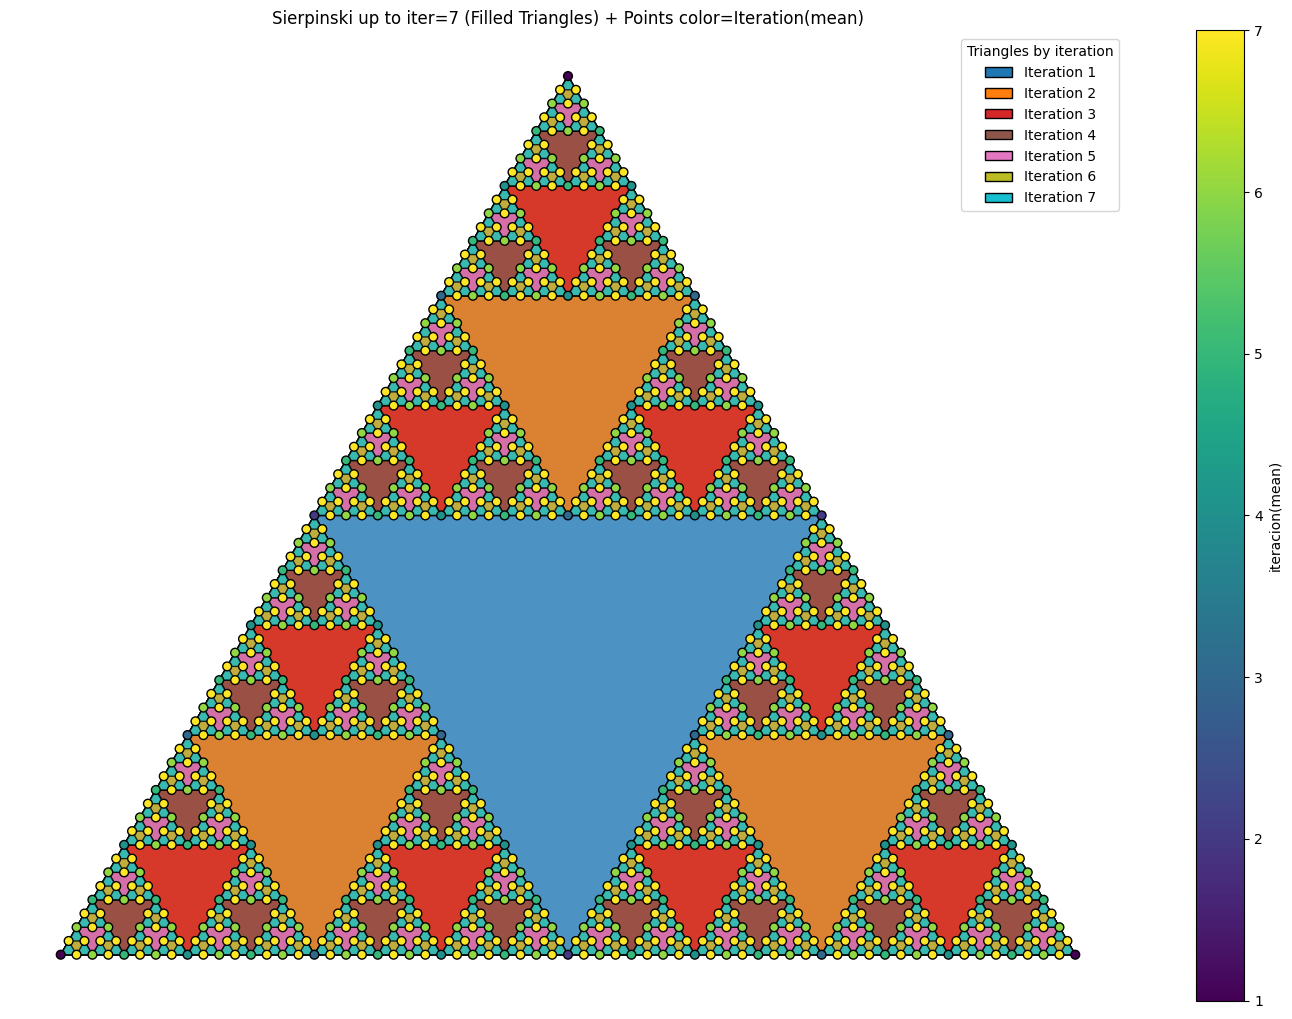

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -----------------------------
# 1) BUILD THE SIERPINSKI DATA
# -----------------------------

def midpoint(A, B):
    return ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)

def subdivide_triangle(tri):
    """
    Given tri = (A,B,C),
    return the 3 corner sub‐triangles
    formed by connecting midpoints.
    """
    A, B, C = tri
    AB_mid = midpoint(A, B)
    BC_mid = midpoint(B, C)
    CA_mid = midpoint(C, A)
    return [
        (A, AB_mid, CA_mid),  # corner that includes A
        (B, BC_mid, AB_mid),  # corner that includes B
        (C, CA_mid, BC_mid)   # corner that includes C
    ]

def sierpinski_triangles_and_points(k):
    """
    Returns:
      triangles_by_iter[i] = list of sub‐triangles introduced at iteration i
      points_list = [(x, y, iterationOfAppearance), ...]
    """
    triangles_by_iter = {}
    point_appearance = {}

    # Iteration 1: one big triangle
    t0 = ((0,0), (1,0), (0.5, np.sqrt(3)/2))
    triangles_by_iter[1] = [t0]
    # Mark these 3 corners as "first appeared in iter=1"
    for corner in t0:
        point_appearance[corner] = 1

    # For each iteration > 1, subdivide the previous iteration's triangles
    for i in range(2, k+1):
        new_tris = []
        for tri in triangles_by_iter[i-1]:
            subs = subdivide_triangle(tri)
            new_tris.extend(subs)
            # Mark new midpoints as iteration i (if not seen before)
            for sub_t in subs:
                for corner in sub_t:
                    if corner not in point_appearance:
                        point_appearance[corner] = i
        triangles_by_iter[i] = new_tris

    # Build the full list of points
    points_list = [(p[0], p[1], it) for (p,it) in point_appearance.items()]
    return triangles_by_iter, points_list


# -----------------------------
# 2) DISTANCES AND STATISTICS
# -----------------------------

def distance_euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def distance_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def distance_minkowski(p1, p2, p=3):
    return (abs(p1[0]-p2[0])**p + abs(p1[1]-p2[1])**p)**(1.0/p)

def distance_aparicion(p1, p2):
    """Difference in iteration of appearance."""
    return abs(p1[2] - p2[2])

def compute_distance_data(points):
    """
    For each point i, compute distances to all others
    in these metrics: Euclid, Manhattan, Minkowski(p=3), Aparicion.
    Then store min, max, mean, median.
    """
    dist_data = {}
    n = len(points)

    def stats(arr):
        arr_np = np.array(arr)
        return {
            'values': arr,
            'min': float(np.min(arr_np)) if len(arr_np)>0 else 0.0,
            'max': float(np.max(arr_np)) if len(arr_np)>0 else 0.0,
            'mean': float(np.mean(arr_np)) if len(arr_np)>0 else 0.0,
            'median': float(np.median(arr_np)) if len(arr_np)>0 else 0.0,
        }

    for i in range(n):
        p_i = points[i]
        dist_eu, dist_man, dist_mink, dist_ap = [], [], [], []
        for j in range(n):
            if i == j:
                continue
            p_j = points[j]
            dist_eu.append(distance_euclid(p_i, p_j))
            dist_man.append(distance_manhattan(p_i, p_j))
            dist_mink.append(distance_minkowski(p_i, p_j, p=3))
            dist_ap.append(distance_aparicion(p_i, p_j))
        iter_val = p_i[2]
        iteration_stats = {
            'values': [iter_val],  # single value
            'min': iter_val,
            'max': iter_val,
            'mean': iter_val,
            'median': iter_val,
        }
        
        dist_data[i] = {
            'point': p_i,
            'euclid':    stats(dist_eu),
            'manhattan': stats(dist_man),
            'minkowski': stats(dist_mink),
            'aparicion': stats(dist_ap),
            'iteracion': iteration_stats
        }
    return dist_data


# -----------------------------
# 3) PLOT: FILL NEW TRIANGLES EACH ITERATION,
#    COLOR POINTS BY A METRIC
# -----------------------------
def plot_filled_new_triangles(
    triangles_by_iter,
    points_list,
    dist_data,
    metric="euclid",
    stat="mean",
    title=None
):
    """
    - For each iteration i=1..k, fill in (with color_i) 
      the sub‐triangles introduced at iteration i.
    - The points are colored by 'metric'('stat') in a scatter with a colorbar.
    - We add a legend showing which color belongs to iteration i.
    """
    import matplotlib.patches as mpatches
    
    if title is None:
        title = f"Sierpinski new triangles + Points color={metric}({stat})"

    fig, ax = plt.subplots(figsize=(18,18))
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title)

    max_iter = max(triangles_by_iter.keys())
    # Discrete colormap with at least 'max_iter' distinct colors
    cmap_iter = plt.cm.get_cmap('tab10', max_iter)

    legend_handles = []
    for i in range(1, max_iter+1):
        tri_list = triangles_by_iter[i]
        if not tri_list:
            continue
        color_i = cmap_iter(i-1)
        # For each new triangle of iteration i, fill it
        for tri in tri_list:
            A, B, C = tri
            polygon = mpatches.Polygon(
                [A, B, C], 
                closed=True,
                facecolor=color_i,    # fill color
                edgecolor='black',    # outline
                linewidth=1.0,
                alpha=0.8
            )
            ax.add_patch(polygon)
        # We'll add a patch to the legend
        patch_for_legend = mpatches.Patch(facecolor=color_i, edgecolor='black',
                                          label=f"Iteration {i}")
        legend_handles.append(patch_for_legend)
    
    ax.legend(handles=legend_handles, loc='upper right',
              title="Triangles by iteration")

    # Now color the points in scatter
    arr_p = np.array(points_list)
    x, y = arr_p[:,0], arr_p[:,1]
    n_points = len(points_list)
    values = np.zeros(n_points)
    for idx in range(n_points):
        values[idx] = dist_data[idx][metric][stat]

    sc = ax.scatter(x, y, c=values, cmap='viridis', 
                    edgecolors='k', s=40, zorder=5)
    cb = fig.colorbar(sc, ax=ax, shrink=0.7)
    cb.set_label(f"{metric}({stat})")

    plt.show()


# -----------------------------
# EXAMPLE USAGE
# -----------------------------
if __name__=="__main__":
    K = 7
    triangles_by_iter, points_list = sierpinski_triangles_and_points(K)
    dist_data = compute_distance_data(points_list)

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="euclid",
        stat="mean",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Euclid(mean)"
    )

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="aparicion",
        stat="mean",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Aparicion(mean)"
    )

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="euclid",
        stat="median",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Euclid(median)"
    )

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="minkowski",
        stat="mean",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Minkowski(mean)"
    )

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="manhattan",
        stat="median",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Manhattan(median)"
    )

    plot_filled_new_triangles(
        triangles_by_iter,
        points_list,
        dist_data,
        metric="iteracion",
        stat="mean",
        title=f"Sierpinski up to iter={K} (Filled Triangles) + Points color=Iteration(mean)"
    )
